# Model Identification for the Temperature Control Lab

Models are essential for feedback control. It may be difficult to understand where and how the model was incorporated into the control system design, and the model may be just a simplistic cause-and-effect understanding of process operation, but be assured that somewhere in the control system is an embedded understanding of process operation.

The notebook is deep dive in creating models for the dynamic response of the Temperature Control Lab to power inputs and external disturbances. The survey of models include:

* Empirical models, single-input single-output
    * Linear first-order
    * Linear first-order with dead-time
   

* Energy balance models
    * Single-input, single-output
        * First order 
        * Second order
    * Multi-input, multi-output
        * Fourth order


* State space models

## Accessing experimental data

Data acquired through normal process operation or experimentation will normally be accessed from a process database. Here we demonstrate reading data stored previously stored in a `.csv` file by a process historian.

### Read data into a Pandas DataFrame

[Pandas](https://pandas.pydata.org/) is one of the most important and widely used Python libraries for data analysis and manipulation. Here we use the library to access a `.csv` file containing previously collected data from a step test of the Temperature Control Lab.

,T1,T2,Q1,Q2
Time,,,,
0.0,21.221,21.446,50.0,0.0
10.0,21.253,21.511,50.0,0.0
20.0,22.188,21.575,50.0,0.0
30.0,23.477,21.672,50.0,0.0
40.0,24.991,21.897,50.0,0.0
...,...,...,...,...
560.0,52.803,36.722,50.0,0.0
570.0,52.803,36.786,50.0,0.0
580.0,52.803,36.754,50.0,0.0


<AxesSubplot:xlabel='time / seconds'>

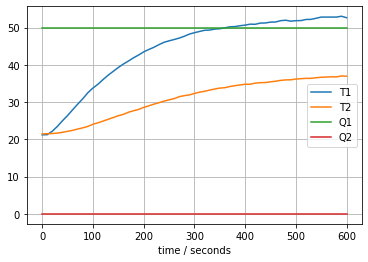

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

# read data file from the Github repository into a Pandas dataframe
data_location = "https://jckantor.github.io/cbe30338-2021/data/Model_Data.csv"
expt = pd.read_csv(data_location)

# set time index
expt = expt.set_index("Time")
t_expt = expt.index

# display data in tabular format
display(expt)

# simple plotting
expt.plot(grid=True, xlabel="time / seconds")

<hr>

**Study Question:**  "Break free from Excel". This exercise demonstrates a technique that you may find useful in your other coursework, particularly the Junior and Senior lab courses. The code cell below contains a link that will export [data stored in a Google Sheet](https://docs.google.com/spreadsheets/d/1rV_oimh-GCYNP-xRP1HNrLvh7P4jZBSmwuqG3VPIaB0/edit?usp=sharing) as a `.csv` file. The file was previously created and share access set for viewing by anyone with a link. Use the Pandas library to read the data into a data frame, display the data table, set the data frame index to the column labeled `Time`, and plot the data. 

<hr>

In [2]:
google_sheet_id = "1rV_oimh-GCYNP-xRP1HNrLvh7P4jZBSmwuqG3VPIaB0"
google_csv_download = f"https://docs.google.com/spreadsheets/d/{google_sheet_id}/gviz/tq?tqx=out:csv"

# write your code here

## Comparing experimental data to model predictions

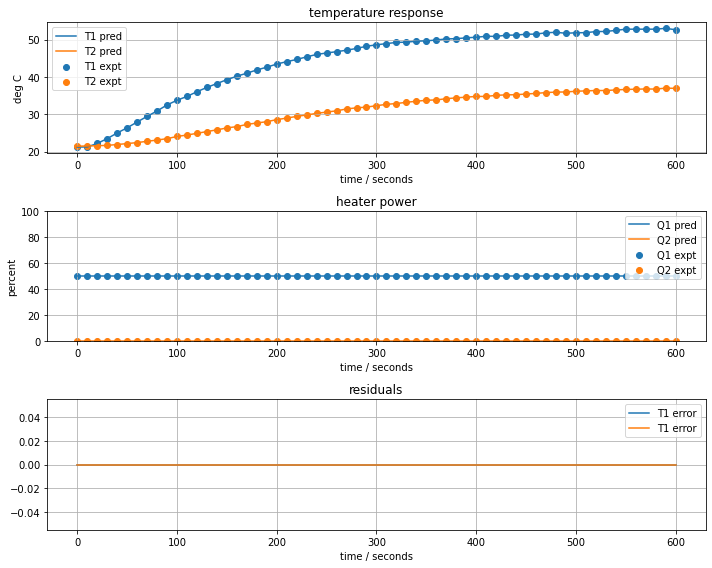

In [3]:
# create a function to compare two data sets
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["T1"], label="T1 expt")
    ax[0].scatter(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg C")
    ax[0].set_title("temperature response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("percent")
    ax[1].set_title("heater power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_title("residuals")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    return
    
# demonstrate by comparing experimental data to itself
plot_data(expt, expt);

## Empirical Modeling

### First order gain and time constant

We previously derived a model for the response T1 of the Temperature Control Lab to a constant input $\bar{u}_1$ as

$$\frac{dT_1}{dt} = -\frac{1}{\tau}(T_1 - T_{amb})+ \frac{K}{\tau}\bar{u}_1$$

where the gain $K$ and the time constant $\tau$ are given by the

\begin{align}
\tau = \frac{C_p}{U_a} \qquad
K = \frac{\alpha P_1}{U_a}
\end{align}

Assuming the system starts with an initial condition $T_1(0) = T_{amb}$, the solution to the differential equation of the system is 

\begin{align}
T_1(t) & = T_{amb}  + K\bar{u}_{1}(1 - e^{-(t-t_0)/\tau})
\end{align}

Given estimates of $K$ and $\tau$, we can construct the preedicted response and compare to the experimental observed response.

Time
0.0     -0.221000
10.0     2.126065
20.0     3.343731
30.0     4.002544
40.0     4.250999
           ...   
560.0   -6.895447
570.0   -6.886649
580.0   -6.878689
590.0   -7.096486
600.0   -6.703969
Name: T1, Length: 61, dtype: float64

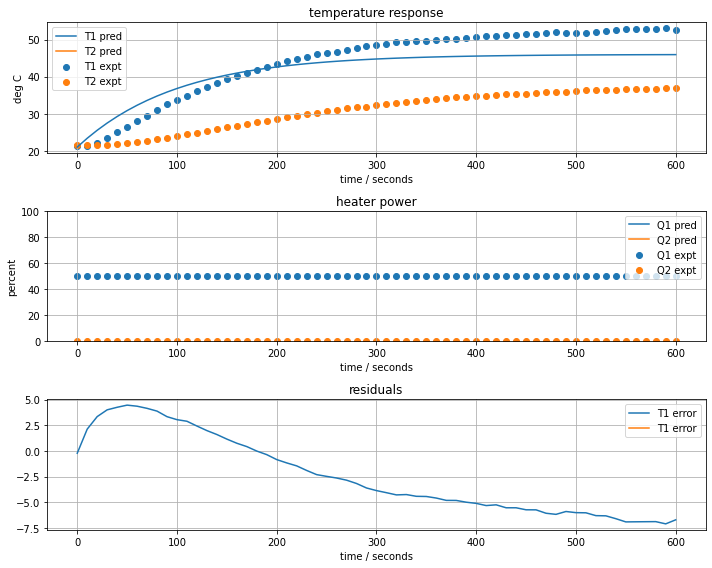

In [4]:
# known parameters
T_amb = 21
u1bar = expt["Q1"].mean()
t_expt = expt.index

# adjustable model parameters
K = 0.5
tau = 100

# create function to create predictions and return residuals
def model_first_order(param, plot=False):
    # unpack list of parameters into variables
    K, tau = param
    
    # create empty prediction data frame
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    
    # calculation prediction
    pred["T1"] = T_amb + K*u1bar*(1 - np.exp(-t_expt/tau))
    
    # plot if desired
    if plot:
        plot_data(expt, pred)
        
    # return residual difference between prediction and experiment
    return pred["T1"] - expt["T1"]

# compare prediction to experiment
model_first_order([K, tau], True)

<hr>

**Study Question:** By trial and error, attempt to find values for the gain $K$ and time constant $\tau$ that provide a useful prediction of the experimentally measured response.

<hr>

Obviously, it would useful to have some way of finding 'optimal' values for $K$ and $\tau$. In this cell we use the [`least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) routine from `scipy.optimize` to find optimal values of the parameters.

K = 0.6810786742351254,  tau = 196.3595429520904


Time
0.0     -0.221000
10.0     1.437844
20.0     2.109734
30.0     2.347839
40.0     2.285121
           ...   
560.0    0.284868
570.0    0.382487
580.0    0.475259
590.0    0.338425
600.0    0.808213
Name: T1, Length: 61, dtype: float64

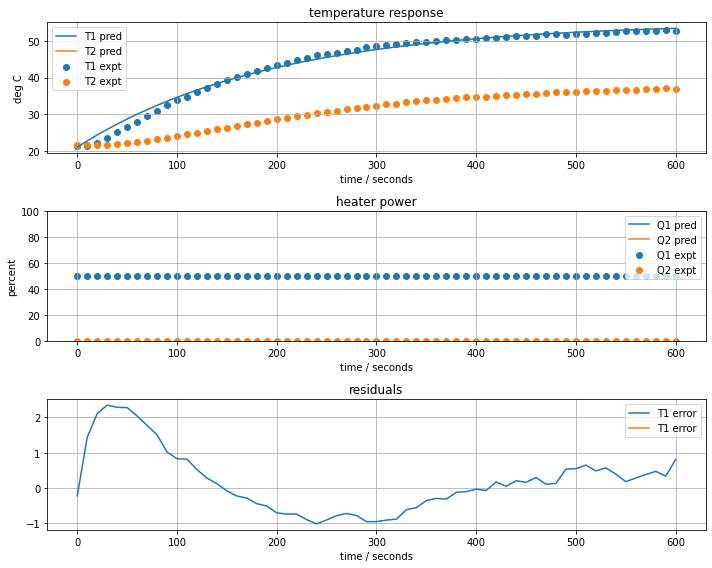

In [5]:
results = least_squares(model_first_order,  [K, tau])
K, tau = results.x
print(f"K = {K},  tau = {tau}")
model_first_order(results.x, True)

### First order with time delay

A first-order with time delay (or 'dead time') are frequenty used in process control to model the delitreous 

\begin{align}
T_1(t) & = T_{amb}  + K\bar{u}_{1}(1 - e^{-(t-t_{delay})/\tau})
\end{align}

$$\frac{dT_1}{dt} = -\frac{1}{\tau}T_1 + \frac{K}{\tau}u_1(t-t_{delay}) + \frac{1}{\tau}T_{amb}$$

Time
0.0     -0.221000
10.0    -0.253000
20.0     0.746790
30.0     1.267800
40.0     1.447077
           ...   
560.0   -2.569846
570.0   -2.520390
580.0   -2.474123
590.0   -2.655840
600.0   -2.229349
Name: T1, Length: 61, dtype: float64

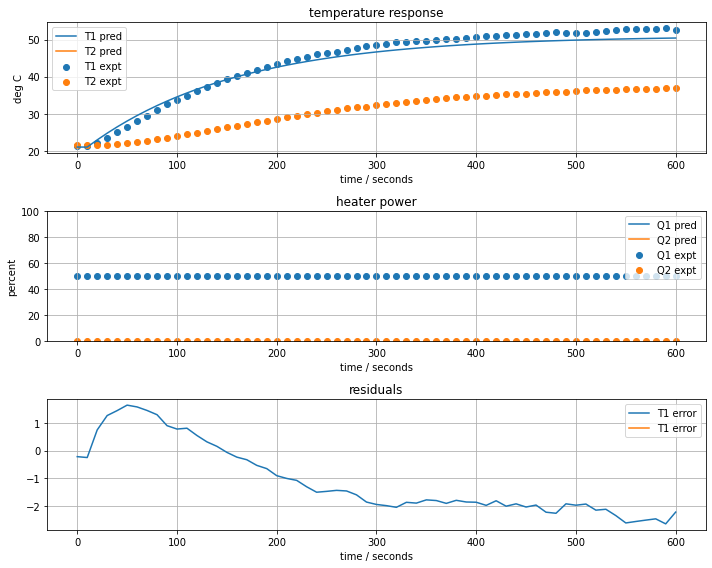

In [6]:
# parameter values and units
T_amb = 21                 # deg C
u1bar = expt["Q1"].mean()
t_expt = expt.index

# adjustable parameters
K = 0.6
tau = 150
t_delay = 10

def model_first_order_delay(param, plot=False):
    K, tau, t_delay = param    
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = [T_amb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb for t in t_expt]
    if plot:
        plot_data(expt, pred)
    return pred["T1"] - expt["T1"]
    
model_first_order_delay([K, tau, t_delay], True)

K = 0.6520728533493453,  tau = 154.47860579512735, time delay = 21.772054298276494


Time
0.0     -0.221000
10.0    -0.253000
20.0    -1.188000
30.0    -0.785879
40.0    -0.362185
           ...   
560.0   -0.199623
570.0   -0.136923
580.0   -0.078154
590.0   -0.248068
600.0    0.189565
Name: T1, Length: 61, dtype: float64

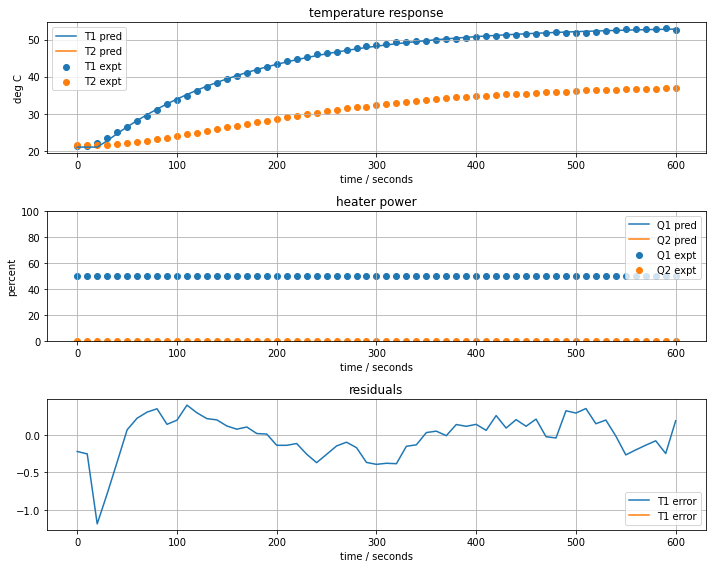

In [7]:
results = least_squares(model_first_order_delay,  [K, tau, t_delay])
K, tau, t_delay = results.x
print(f"K = {K},  tau = {tau}, time delay = {t_delay}")
model_first_order_delay(results.x, True)

## First order Energy balance model

We previously developed a model comprising a single differential equation for the temperature response of a heater/sensor assembly. Given $u_1(t)$ and an initial condition $T_{amb}$, the heater/sensor temperature is given by 

$$\frac{dT_1}{dt} = -\frac{U_a}{C_p}T_1 + \frac{\alpha P_1}{C_p} u_1(t) + \frac{U_a}{C_p}T_{amb}$$

Several of the key parameters are known. These include $\alpha$ which was determined by direct measurement, $P1$ which is set in the Arduino firmware. We  assume the ambient temperature $T_{amb}$ is measurable and known. 

The unknown parameters are the heat capacity $C_p$ and heat transfer coefficient $U_a$. We wish to find values of the unknown parameters that allow the model response to mimic responses measured by experiment.

Here we show a simulation of this model.

In [8]:
# parameter values and units
T_amb = 21             # deg C
P1 = 200               # P1 units
P2 = 100               # P2 units
alpha = 0.00016        # watts / (units P1 * percent U1)

# input function
def u1(t):
    return np.interp(t, t_expt, expt["Q1"])

def u2(t):
    return np.interp(t, t_expt, expt["Q2"])

The unknown parameters are the heat capacity $C_p$ and heat transfer coefficient $U_a$. We wish to find values of the unknown parameters that allow the model response to mimic responses measured by experiment.

Here we show a simulation of this model.

Time
0.0     -0.221000
10.0     2.305582
20.0     3.724586
30.0     4.601597
40.0     5.082666
           ...   
560.0   -0.111357
570.0   -0.086947
580.0   -0.064244
590.0   -0.268356
600.0    0.136861
Name: T1, Length: 61, dtype: float64

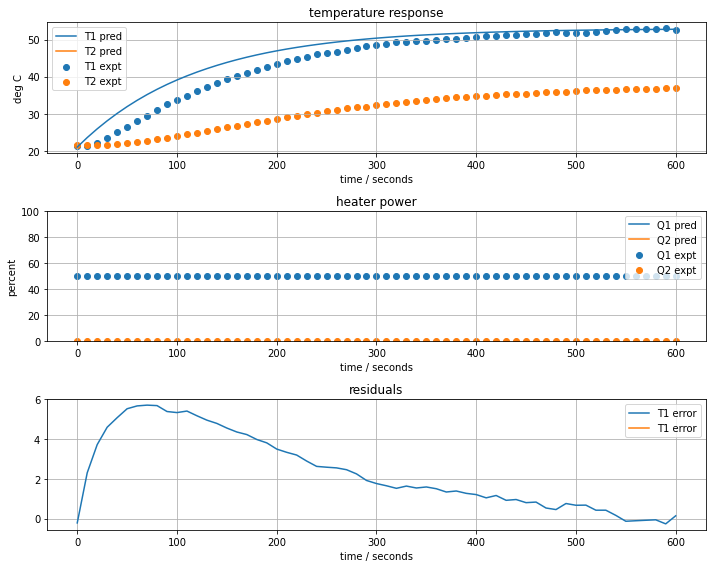

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
Cp = 6                 # joules/deg C
Ua = 0.05              # watts/deg C

def model_energy_first_order(param, plot=False):
    # unpack the adjustable parameters
    Cp, Ua = param

    # model solution
    def deriv(t, y):
        T1 = y[0]
        return -(Ua/Cp)*T1 + (alpha*P1/Cp)*u1(t) + (Ua/Cp)*T_amb

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb], t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[0]

    # plot solution
    if plot:
        plot_data(expt, pred)
        
    return pred["T1"] - expt["T1"]
    
model_energy_first_order([Cp, Ua], True)

## Find the best fit

Cp = 9.229886459160445,  Ua = 0.046971454569863326


Time
0.0     -0.221000
10.0     1.437129
20.0     2.108398
30.0     2.345976
40.0     2.283637
           ...   
560.0    0.285965
570.0    0.382852
580.0    0.475093
590.0    0.338030
600.0    0.808000
Name: T1, Length: 61, dtype: float64

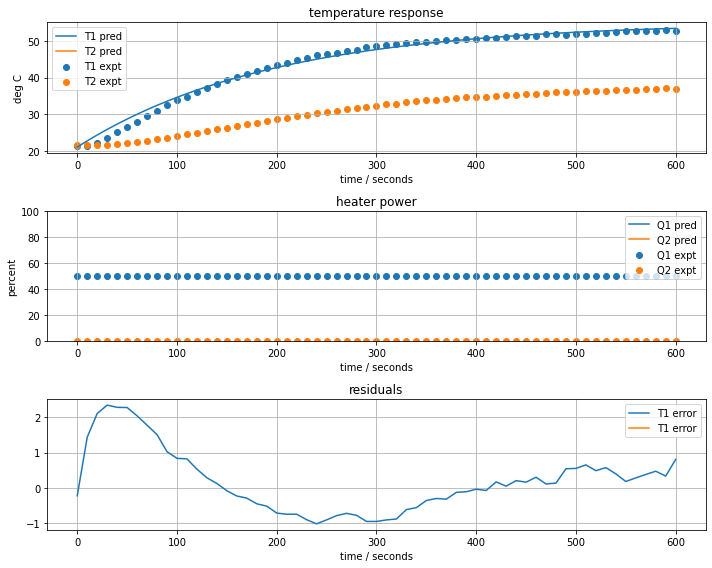

In [10]:
results = least_squares(model_energy_first_order,  [Cp, Ua])
Cp, Ua = results.x
print(f"Cp = {Cp},  Ua = {Ua}")
model_energy_first_order(results.x, True)

## Second-order model

### Dynamics of the Heater/Sensor System

The previous results are not yet fully satisfactory. We're still missing the initial 'lag' in response of the measured temperature. 

For this third model, we consider the possibility that the heater and sensor may not be at the same temperature. In other words, that the heater/sensor assembly is not at a uniform temperature. To account for this possibility, we introduce $T_{H,1}$ to denote the temperature of heater one and $T_{S,1}$ to denote the temperature of the corresponding sensor. We'll further assume that sensor mainly exchanges heat with the heater, and the dominant heat transfer to the surroundings is through the heat sink attached to the heater.

This motivates a model

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}

where $C^H_p$ and $C^S_p$ are the gross heat capacities of the heater and sensor, respectively, and $U_b$ is a new heat transfer coefficient characterizing the exchange of heat between the heater and sensor.

\begin{align}
\frac{dT_{H,1}}{dt} & = -\frac{U_a+U_b}{C^H_p}T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1}) 
\end{align}

Where measured temperature, that is, the temperature recorded by the Arduino, $T_1$ is given by

$$T_1 = T_{S,1}$$

Time
0.0     -0.221000
10.0     0.371773
20.0     0.895562
30.0     1.395004
40.0     1.774688
           ...   
560.0   -0.210368
570.0   -0.188967
580.0   -0.148499
590.0   -0.323733
600.0    0.093363
Name: T1, Length: 61, dtype: float64

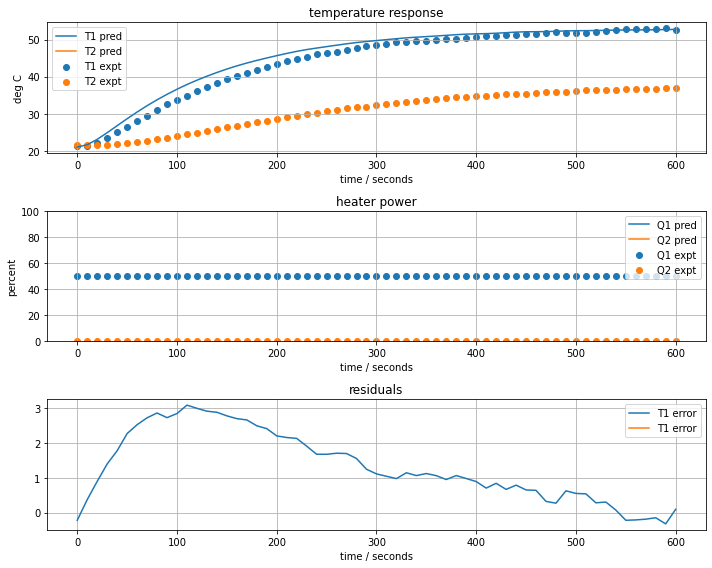

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C


def model_energy_second_order(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub = param

    # model solution
    def deriv(t, y):
        T1H, T1S = y
        dT1H = (-(Ua + Ub)*T1H + Ub*T1S + alpha*P1*u1(t) + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        return [dT1H, dT1S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb, T_amb], t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
        
    return pred["T1"] - expt["T1"]
    
model_energy_second_order([CpH, CpS, Ua, Ub], plot=True)

### Best fit

CpH = 2.1819127156760283,  CpS = 1.878312055293452,   Ua = 0.04956661570349656,  Ub = 0.021187799850674392


Time
0.0     -0.221000
10.0     0.104481
20.0     0.063797
30.0    -0.007664
40.0    -0.117127
           ...   
560.0   -0.289049
570.0   -0.245878
580.0   -0.203222
590.0   -0.386367
600.0    0.039925
Name: T1, Length: 61, dtype: float64

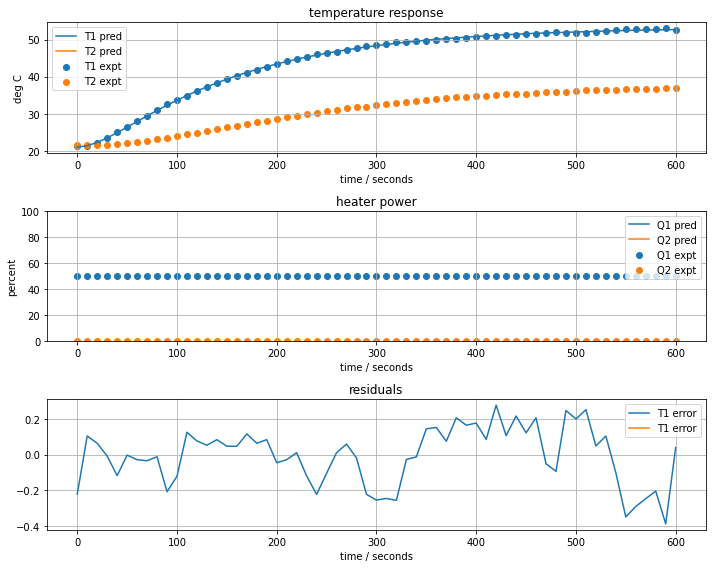

In [12]:
results = least_squares(model_energy_second_order,  [CpH, CpS, Ua, Ub])
CpH, CpS, Ua, Ub = results.x
print(f"CpH = {CpH},  CpS = {CpS},   Ua = {Ua},  Ub = {Ub}")
model_energy_second_order(results.x, True)

## Fourth-Order Multi-Input Multi-Output Model

### Model derivation

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + U_c(T_{H,2}-T_{H,1})  + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1})  \\
C^H_p\frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{S,2} - T_{H,2}) + U_c(T_{H,1}-T_{H,2}) + \alpha P_2 u_2\\
C^S_p\frac{dT_{S,2}}{dt} & = U_b(T_{H,2} - T_{S,2}) 
\end{align}

where

\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}

### Standard form

\begin{align}
\frac{dT_{H,1}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{U_c}{C^H_p}T_{H,2}  + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1})  \\
\frac{dT_{H,2}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})T_{H,2} + \frac{U_b}{C^H_p}T_{S,2} + \frac{U_c}{C^H_p}T_{H,1}  + \frac{\alpha P_2}{C^H_p}u_2 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,2}}{dt} & = \frac{U_b}{C^S_p}(T_{H,2} - T_{S,2}) 
\end{align}

where

\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}

array([ -0.221     ,   0.34640496,   0.76940428,   1.05824442,
         1.13171249,   1.24645305,   1.07316775,   0.81586616,
         0.48007917,  -0.13344645,  -0.48890253,  -0.70921588,
        -1.25124638,  -1.76745403,  -2.20823788,  -2.69742627,
        -3.14122854,  -3.52330422,  -4.01831601,  -4.40206324,
        -4.88886002,  -5.19721912,  -5.48385191,  -5.96815841,
        -6.40553965,  -6.57439776,  -6.70435903,  -6.9013846 ,
        -7.2455444 ,  -7.69003022,  -7.92579427,  -8.09662387,
        -8.30244458,  -8.28467125,  -8.45397113,  -8.44203263,
        -8.55229841,  -8.76329137,  -8.79264212,  -8.97090733,
        -9.05270848,  -9.21073629,  -9.11325468,  -9.42975647,
        -9.44638557,  -9.61415333,  -9.564619  ,  -9.87641255,
       -10.01102868,  -9.74099527,  -9.82511837,  -9.804095  ,
       -10.08438906, -10.11845575, -10.39033103, -10.67585924,
       -10.64774194, -10.64625393, -10.63882106, -10.84765596,
       -10.44699971,  -0.446     ,  -0.48503157,  -0.44

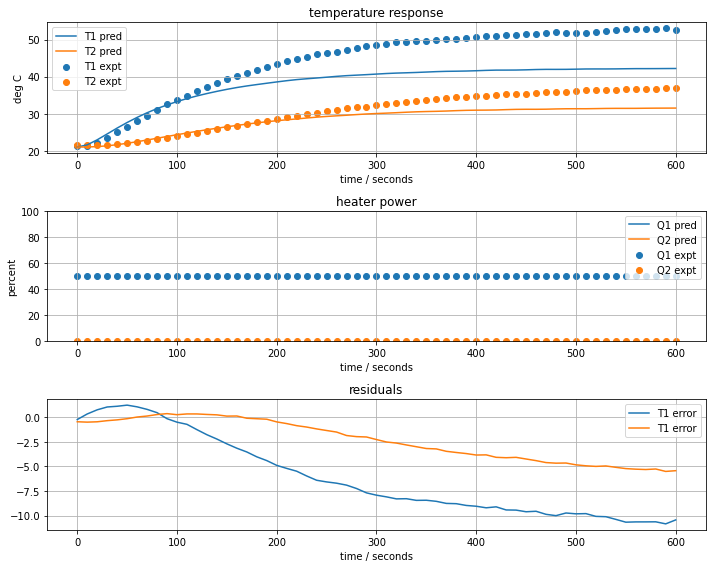

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C
Uc = 0.05              # watts/deg C

def model_energy_fourth_order(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub, Uc = param  

    # model solution
    def deriv(t, y):
        T1H, T1S, T2H, T2S= y
        dT1H = (-(Ua + Ub + Uc)*T1H + Ub*T1S + Uc*T2H + alpha*P1*u1(t) + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        dT2H = (-(Ua + Ub + Uc)*T2H + Ub*T2S + Uc*T1H + alpha*P2*u2(t) + Ua*T_amb)/CpH
        dT2S = Ub*(T2H - T2S)/CpS
        return [dT1H, dT1S, dT2H, dT2S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb]*4, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]
    pred["T2"] = soln.y[3]

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
    
    err1 = np.array(pred["T1"] - expt["T1"])
    err2 = np.array(pred["T2"] - expt["T2"])
    
    return np.concatenate((err1, err2))
    
model_energy_fourth_order([CpH, CpS, Ua, Ub, Uc], plot=True)

CpH = 4.4642229433310705,  CpS = 0.8190620772014501,   Ua = 0.032226735496058236,  Ub = 0.01862452210295832,  Uc = 0.033554024370968105


array([-0.221     ,  0.10032875,  0.05752008, -0.00405231, -0.10773464,
        0.01920575,  0.02181627,  0.03268211,  0.05934022, -0.12621606,
       -0.02560712,  0.22155593,  0.1591108 ,  0.12013875,  0.14267453,
        0.09875163,  0.08540225,  0.13037096,  0.05135871,  0.04902892,
       -0.09703112, -0.09303583, -0.06500128, -0.20674525, -0.32566391,
       -0.22615469, -0.12616143, -0.08732116, -0.16917961, -0.37119119,
       -0.39871904, -0.38303497, -0.3863195 , -0.15266185, -0.13605994,
        0.01670928,  0.02122981, -0.05314745,  0.08779108,  0.06239935,
        0.09510954,  0.02842961,  0.244774  ,  0.09824684,  0.2274448 ,
        0.14545713,  0.23302579, -0.01549275, -0.04315274,  0.31607625,
        0.29086137,  0.36550651,  0.18295226,  0.25477598,  0.05819174,
       -0.19055652, -0.12624109, -0.06348875, -0.00238632, -0.16838589,
        0.27369513, -0.446     , -0.50119113, -0.51353834, -0.49453376,
       -0.52704126, -0.5249296 , -0.46191438, -0.43668769, -0.33

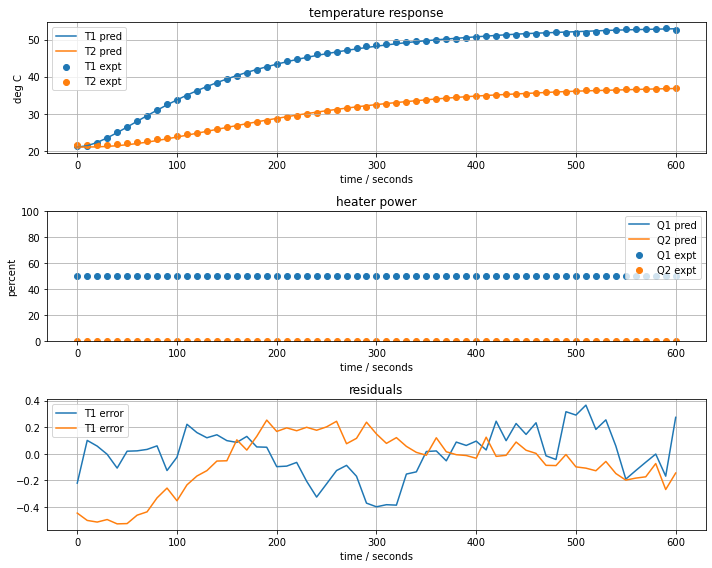

In [14]:
results = least_squares(model_energy_fourth_order,  [CpH, CpS, Ua, Ub, Uc])
CpH, CpS, Ua, Ub, Uc = results.x
print(f"CpH = {CpH},  CpS = {CpS},   Ua = {Ua},  Ub = {Ub},  Uc = {Uc}")
model_energy_fourth_order(results.x, True)

## Lab Assignment 2: Identification of a Multi-input, Multi-output Model for the Temperature Control Laboratory

Create one or more notebooks to show your results for the following exercises. The model you develop in this exercise will be used in the remainder of the semester for simulation and control design for your copy of the Temperature Control Laboratory.

### Exercise 1.

Write two python functions, one called u1(t) and the other u2(t), that create the following input signals that will be used to test the Temperature Control Lab.

* u1(t) and u2(t) are initially zero.
* At time t=20, u1(t) jumps to 60% power, u2(t) remains at zero.
* At time t=620, u2(t) jumps to 60% power, u1(t) remains at 60.
* At time t=1020, u1(t) returns to 0, u2(t) remains at 60.
* At time t=1420, u2(t) returns to zero. Experiment is over.

Develop these functions, and plot the results for t=-100 to t=1800 (yes, beyond the end of the experiment) showing correct performance.

### Exercise 2.

Use the functions created in Exercise 1 to obtain experimental data for your Temperature Control Lab. This will take some time (about 1/2 hour if everything works perfectly). Record T1, T2, Q1, Q2 using the Historian. Be careful to ...

* Set P1=200, P2=100 before the experiment begins
* Let the device reach equilibrium with ambient temperture before starting. Allow at least 10 minutes. Don't shortcut this (as tempting as that may be) since you will only get data that provide headaches later. "Go slow to go fast."
* You might use the box the kit came in to put a little "tent" over the device to protect from air currents.
* Before starting, be sure the heat sinks are not touching, and that everything looks in good shape.
* If your thermal paste looks like it is melting, stop the experiment immediately. Lower P1 and P2 by 25% and start over. Note this in your lab report.

Save this data to a .csv file. 

### Exercise 3.

To avoid overwriting or damaging the data you collected in Exercise 2, create a separate notebook for model fitting. Fit two models to your data:

* Fit the first-order plus delay model to the results for "T1" using data up to t=620 (i.e, the data before you turn on the second heater.).  What are the gain, time-constant, and time delay for your device?

* Fit the fourth-order model (alternatively, the state-space model if you're comfortable with that formulation), and report all heat capacities, heat transfer coefficients. Note that you're fitting a two-input, two-output model which is very challenging. So the fit may not look quite as good as those shown above when u2(t) was held constant.